<center><strong><h1>licence plate detection

In [1]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
from PIL import Image
plt.style.use('default')  #using black for backgrounf

##Setting up kaggle API to download dataset directly from their Website

In [2]:
from google.colab import files
files.upload() 

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mondhirch","key":"03a491ad2fe5eb1a1d2cdacf1282a741"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

#Change the permission
!chmod 600 ~/.kaggle/kaggle.json

## Downloading the datasets

In [4]:
#The big dataset
!kaggle datasets download -d xairete/car-plates-ocr

100% 6.04G/6.05G [00:35<00:00, 202MB/s]
100% 6.05G/6.05G [00:35<00:00, 182MB/s]


### Unzipping

In [5]:
from zipfile import ZipFile
file_name="car-plates-ocr.zip"

with ZipFile(file_name,"r") as zip:
  zip.extractall()
  print("Done")

Done


## Data Preperation

In [6]:
!mkdir "/content/data/train_jpg/"
!mv "/content/data/train/"*.jpg "/content/data/train_jpg/"


In [11]:
#move a sample 1000 out of 17000 to do check
!mkdir "/content/data/train_3000/"
!ls /content/data/train_jpg/* | head -3000 | xargs -I{} cp {} /content/data/train_3000/

## Appending Images to X[] (big datatset)

### we need anotations before

In [3]:
import json
with open("/content/data/train.json", "r") as read_file:
    data = json.load(read_file)


In [4]:
IMAGE_SIZE = 224

img_dir = "/content/data/train_3000" # Enter Directory of all images 
data_path = os.path.join(img_dir,'*g')
files = glob.glob(data_path)

#We sort the images in alphabetical order to match them to the xml files containing the annotations of the bounding boxes
files.sort() 

X=[]
y=[]
for f1 in files:
    img = cv2.imread(f1)
    height = img.shape[0]
    width = img.shape[1]
    img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE))
    X.append(img)
    path_list = f1.split(os.sep)
    file_name=path_list[-1]
    index=int(file_name[:-4])
    y.append([ int(data[index]['nums'][0]["box"][0][0]/(width/IMAGE_SIZE)), int(data[index]['nums'][0]["box"][0][1]/(height/IMAGE_SIZE)), int(data[index]['nums'][0]["box"][2][0]/(width/IMAGE_SIZE)), int(data[index]['nums'][0]["box"][2][1]/(height/IMAGE_SIZE))])
    

## Transforming To Ndarray

In [5]:
X=np.array(X)
y=np.array(y)

In [6]:
#Renormalisation
X = X / 255
y = y / 255

## Split the data

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

## Creating the model

In [8]:
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.applications.vgg16 import VGG16

In [9]:
# Create the model
model = Sequential()
model.add(VGG16(weights="imagenet", include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="sigmoid"))

model.layers[-6].trainable = False

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 128)               3211392   
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 4)                 260       
                                                                 
Total params: 17,951,108
Trainable params: 3,236,420
Non

In [10]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

In [11]:
#training the model
train = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32, verbose=1)

Epoch 1/50
68/68 [==============================] - 26s 194ms/step - loss: 0.1237 - accuracy: 0.0148 - val_loss: 0.0825 - val_accuracy: 0.0083
Epoch 2/50
68/68 [==============================] - 11s 161ms/step - loss: 0.0345 - accuracy: 0.3991 - val_loss: 0.0055 - val_accuracy: 0.7875
Epoch 3/50
68/68 [==============================] - 11s 162ms/step - loss: 0.0042 - accuracy: 0.8440 - val_loss: 0.0045 - val_accuracy: 0.8583
Epoch 4/50
68/68 [==============================] - 11s 162ms/step - loss: 0.0021 - accuracy: 0.9083 - val_loss: 0.0045 - val_accuracy: 0.8333
Epoch 5/50
68/68 [==============================] - 11s 164ms/step - loss: 0.0013 - accuracy: 0.9449 - val_loss: 0.0044 - val_accuracy: 0.8833
Epoch 6/50
68/68 [==============================] - 11s 166ms/step - loss: 9.4614e-04 - accuracy: 0.9444 - val_loss: 0.0047 - val_accuracy: 0.8750
Epoch 7/50
68/68 [==============================] - 11s 166ms/step - loss: 7.5503e-04 - accuracy: 0.9468 - val_loss: 0.0052 - val_accuracy

<h1> Testing

In [12]:
# Test
scores = model.evaluate(X_test, y_test, verbose=0)
print("Score : %.2f%%" % (scores[1]*100))

Score : 90.33%


## Plot Accuracy Curve

In [13]:
def plot_scores(train) :
    accuracy = train.history['accuracy']
    val_accuracy = train.history['val_accuracy']
    epochs = range(len(accuracy))
    plt.plot(epochs, accuracy, 'b', label='Accuracy')
    plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

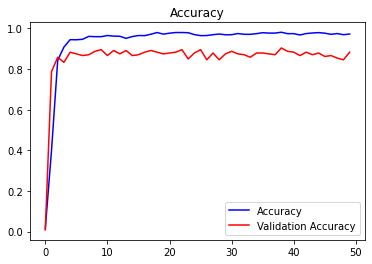

In [14]:
plot_scores(train)

<h2> Export the model

In [15]:
model.save('my_model.h5') 

##### To load
# new_model = tf.keras.models.load_model('saved_model/my_model')
